In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%load_ext autoreload
%autoreload 2

In [2]:
from tqdm.notebook import tnrange, tqdm
from jax import random, vmap, jit, value_and_grad
from jax.experimental import optimizers, stax
import jax.numpy as np
import staxplusplus as spp
from normalizing_flows import *
from util import *
import matplotlib.pyplot as plt
from datasets import get_cifar10_data, get_mnist_data

In [3]:
x_train, y_train, x_test, y_test = get_cifar10_data()

# Build the RealNVP Model

In [4]:
# https://github.com/chrischute/real-nvp/blob/master/models/resnet/residual_block.py
def ResidualBlock(n_channels):
    network = spp.sequential(spp.BatchNorm(), 
                             spp.Relu(), 
                             spp.Conv(n_channels, filter_shape=(3, 3), padding=((1, 1), (1, 1))),
                             spp.BatchNorm(),
                             spp.Relu(),
                             spp.Conv(n_channels, filter_shape=(3, 3), padding=((1, 1), (1, 1))))
    return spp.Residual(network)

In [5]:
# https://github.com/chrischute/real-nvp/blob/master/models/resnet/resnet.py
def ResNet(n_mid_channels, n_out_channels, n_blocks, filter_shape, padding):
    
    skip_filter = (1, 1)
    skip_padding = ((0, 0), (0, 0))
    
    out_filter = (1, 1)
    out_padding = ((0, 0), (0, 0))
    
    block_gen = lambda :spp.sequential(ResidualBlock(n_mid_channels), 
                                       spp.Conv(n_mid_channels, filter_shape=skip_filter, padding=skip_padding))
    
    blocks = [block_gen() for _ in range(n_blocks)]
    
    middle_blocks = spp.sequential(spp.FanOut(n_blocks), spp.parallel(*blocks), spp.FanInSum())
    
    network = spp.sequential(spp.BatchNorm(),
                             spp.FanOut(2),
                             spp.parallel(spp.Identity(),
                                          spp.ScalarMultiply(-1.0)),
                             spp.FanInConcat(),
                             spp.Relu(),
                             spp.Conv(n_mid_channels, filter_shape=filter_shape, padding=padding),
                             spp.FanOut(2),
                             spp.parallel(spp.Conv(n_mid_channels, filter_shape=filter_shape, padding=padding),
                                          middle_blocks),
                             spp.FanInSum(),
                             spp.BatchNorm(),
                             spp.Relu(),
                             spp.FanOut(2),
                             spp.parallel(spp.Conv(n_out_channels, filter_shape=out_filter, padding=out_padding),
                                          spp.Conv(n_out_channels, filter_shape=out_filter, padding=out_padding)))
    
    return network

In [6]:
# https://github.com/chrischute/real-nvp/blob/master/models/real_nvp/coupling_layer.py
def CouplingLayer(n_mid_channels, n_blocks):
    
    def Transform(out_shape):
        n_out_channels = out_shape[-1]
        return ResNet(n_mid_channels, n_out_channels, n_blocks, filter_shape=(3, 3), padding=((1, 1), (1, 1)))
    
    return sequential_flow(CheckerboardSqueeze(), AffineCoupling(Transform), CheckerboardUnSqueeze(), Reverse() )

In [7]:
# https://github.com/chrischute/real-nvp/blob/master/models/real_nvp/real_nvp.py
def RealNVP(n_mid_channels, n_blocks):
      return sequential_flow(Logit(),
                             CouplingLayer(n_mid_channels, n_blocks),
                             CheckerboardFactor(2),
                             factored_flow(Identity(),
                                           sequential_flow(CouplingLayer(n_mid_channels, n_blocks),
                                                           CheckerboardFactor(2),
                                                           factored_flow(Identity(),
                                                                         CouplingLayer(n_mid_channels, n_blocks)),
                                                           CheckerboardCombine(2))),
                             CheckerboardCombine(2),
                             CouplingLayer(n_mid_channels, n_blocks),
                             CheckerboardFactor(2),
                             factored_flow(Identity(),
                                           sequential_flow(CouplingLayer(n_mid_channels, n_blocks),
                                                           CheckerboardFactor(2),
                                                           factored_flow(Identity(),
                                                                         CouplingLayer(n_mid_channels, n_blocks)),
                                                           CheckerboardCombine(2))),
                             CheckerboardCombine(2),
                             CouplingLayer(n_mid_channels, n_blocks),
                             CouplingLayer(n_mid_channels, n_blocks),
                             UnitGaussianPrior(axis=(-3, -2, -1)))

# Initialize the model

In [8]:
init_fun, forward, inverse = RealNVP(3, 3)

key = random.PRNGKey(0)
name, output_shape, params, state = init_fun(key, x_train.shape[1:], ())
output_shape

(32, 32, 3)

# Create the loss function and optimizer

In [9]:
@jit
def nll(params, state, x, **kwargs):
    cond = ()
    log_px, z, updated_state = forward(params, state, np.zeros(x.shape[0]), x, cond, **kwargs)
    flat_params, _ = ravel_pytree(params)
    return -np.mean(log_px) + 0.05*np.linalg.norm(flat_params), updated_state

# Create the gradient function
valgrad = value_and_grad(nll, has_aux=True)
valgrad = jit(valgrad)

In [10]:
opt_init, opt_update, get_params = optimizers.adam(0.0001)
opt_update = jit(opt_update)
opt_state = opt_init(params)

# Train

In [11]:
batch_size = 64

losses = []
pbar = tnrange(50000)
for i in pbar:
    key, *keys = random.split(key, 3)
    
    batch_idx = random.randint(keys[0], (batch_size,), minval=0, maxval=x_train.shape[0])
    x_batch = x_train[batch_idx,:]
    
    params = get_params(opt_state)
    (val, state), grad = valgrad(params, state, x_batch, key=keys[1], test=TRAIN)
    opt_state = opt_update(i, grad, opt_state)
    
    losses.append(val)
    pbar.set_description('Negative Log Likelihood: %5.3f'%(val))

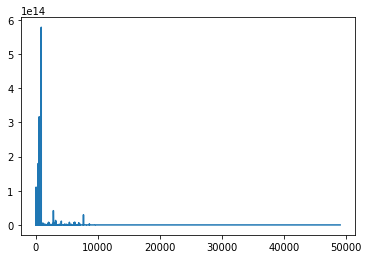

In [12]:
plt.plot(losses[1000:])

# Generate Samples

In [13]:
n_samples = 2
z = random.normal(key, (n_samples,) + x_train.shape[1:])
_, fz, _ = inverse(params, state, np.zeros(n_samples), z, (), test=TEST)

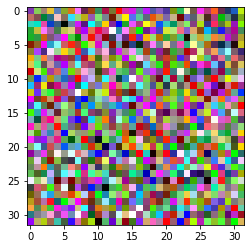

In [14]:
plt.imshow(fz[0])